In [1]:
%%bash
pip install gensim
pip install emoji --no-deps
pip install stopwordsiso


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Import Libraries

In [2]:
import re
import string
import emoji
import pandas as pd
import nltk
import stopwordsiso
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from stopwordsiso import stopwords
import pickle
import time

import torch
from transformers import BertModel, BertTokenizer
import gc
from transformers import (
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel
)

from sklearn.model_selection import train_test_split
import re
import os
import requests
import gc
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read Data

In [3]:
train = pd.read_csv('HASOC19/german_dataset/german_dataset.tsv', sep='\t')
test = pd.read_csv('HASOC19/german_dataset/hasoc_de_test_gold.tsv', sep='\t')

train.drop(["text_id", 'task_2'], axis=1, inplace=True)
test.drop(["text_id", 'task_2'], axis=1, inplace=True)

# rename task_1 to label
train.rename(columns={'task_1': 'label'}, inplace=True)
test.rename(columns={'task_1': 'label'}, inplace=True)

# Map the labels to integers
label_map = {'HOF': 1, 'NOT': 0}

train['label'] = train['label'].map(label_map)
test['label'] = test['label'].map(label_map)

In [4]:
train.shape, test.shape

((3819, 2), (850, 2))

## Data Pre-processing

In [5]:
def preprocess_german_text(df):
    """
    Preprocess German text data in the 'text' column by:
    - Removing mentions (@USERS)
    - Removing hashtags
    - Removing URLs
    - Removing punctuation
    - Collapsing multiple spaces
    - Converting text to lowercase
    - Replacing umlauts with equivalent character combinations
    - Expanding common abbreviations
    - Removing German stopwords
    
    Parameters:
        df (pd.DataFrame): The dataset containing the 'text' column.
        
    Returns:
        pd.DataFrame: The processed dataset with the 'text' column cleaned.
    """
    # Removing @USER mentions
    df['text'] = df['text'].str.replace(r'@\w+\s*', '', regex=True)
    
    # Removing hashtags
    df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)
    
    # Removing URLs
    df['text'] = df['text'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    
    # Removing punctuation
    df['text'] = df['text'].str.replace(f'[{string.punctuation}]', '', regex=True)
    
    # Removing digits
    df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
    
    # Removing extra spaces
    df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # Converting text to lowercase
    df['text'] = df['text'].str.lower()
    
    # Replacing German umlauts and Eszett
    df['text'] = df['text'].str.replace('ä', 'ae').str.replace('ö', 'oe').str.replace('ü', 'ue').str.replace('ß', 'ss')
    
    # Expand common German abbreviations (example set; expand based on dataset needs)
    df['text'] = df['text'].str.replace(r'\bz\.b\.\b', 'zum beispiel', regex=True)  # z.B. -> zum Beispiel
    df['text'] = df['text'].str.replace(r'\bu\.a\.\b', 'unter anderem', regex=True)  # u.a. -> unter anderem
    
    return df

def process_text_with_emojis(text):
    """
    Replace emojis with descriptive text and handle demojized content.
    """
    text_without_emojis = emoji.demojize(text)
    return text_without_emojis

In [6]:
# Apply preprocessing functions to the train and test datasets
train = preprocess_german_text(train)
test = preprocess_german_text(test)

# Replace emojis with text
train["text"] = train["text"].apply(process_text_with_emojis)
test["text"] = test["text"].apply(process_text_with_emojis)

In [7]:
# Load German stopwords
if stopwordsiso.has_lang("de"):  # Check if stopwords exist for German
    german_stopwords = stopwords("de")

def remove_stopwords(text):
    """
    Remove German stopwords from text.
    """
    words = text.split()
    filtered_words = [word for word in words if word not in german_stopwords]
    return ' '.join(filtered_words)

# Remove German stopwords
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

# Handle compound words (optional; split long words if necessary)
def split_compound_words(sentence):
    """
    Add spaces between words in German compound words, if needed (custom implementation).
    This can be improved with specific tools for compound splitting.
    """
    # Example heuristic: split words longer than 20 characters
    words = sentence.split()
    processed_words = [re.sub(r'([a-zA-Z]{10,})', r'\1 ', word) if len(word) > 20 else word for word in words]
    return ' '.join(processed_words)

train['text'] = train['text'].apply(split_compound_words)
test['text'] = test['text'].apply(split_compound_words)

# Replace multiple consecutive spaces
train['text'] = train['text'].str.replace(r'\s+', ' ', regex=True).str.strip()
test['text'] = test['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [8]:
# remove rows with empty text
train = train[train['text'] != '']
test = test[test['text'] != '']

In [9]:
train.head()

,text,label
0,frank rennicke – stolz,0
1,ansehenund bitte teilenteilenteilen,0
2,mohamed erkennt deutsches koelner dom kaputt s...,0
3,brutale islamische diktatur richtete kuerzlich...,0
4,bundespolizei quartal illegale einreisen regis...,0


In [10]:
test.head()

,text,label
0,gruene intelligenz bestie eckhardt prangert ti...,1
1,deutschlandlied sinn unsinn,0
3,esc kandidatinnen schuld point publicdenn jung...,1
4,scheinbar bekommt sarahs conners sohn vincentb...,1
5,ueberzeugen politische linkedie frau gleichber...,1


## Traditional Machine Learning Models

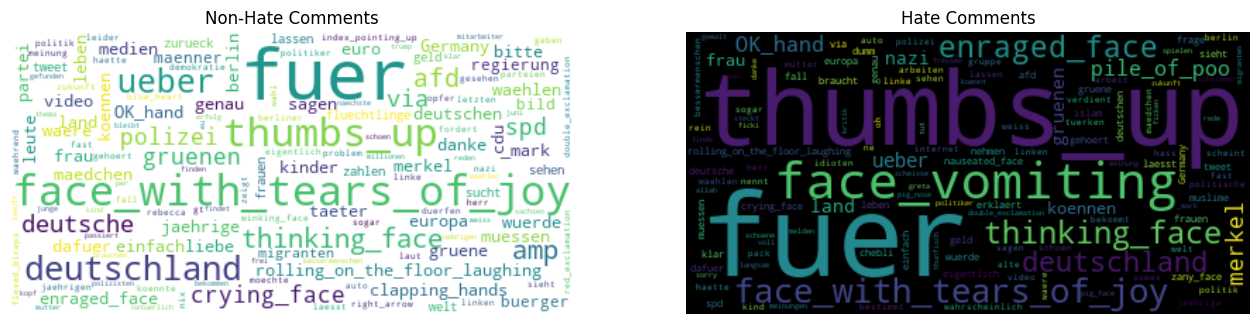

In [11]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train['text'][train.label == 0])
text_neg = " ".join(train['text'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

### Create Word Embeddings

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from stopwordsiso import stopwords

# Load German stop words
if stopwordsiso.has_lang("de"):
    german_stopwords = list(stopwords("de"))  # Convert the set to a list
else:
    german_stopwords = []  # Fallback in case stop words are unavailable

# Initialize the TfidfVectorizer with German stop words
tfidf = TfidfVectorizer(max_features=2000, stop_words=german_stopwords)

# Fit the TfidfVectorizer on the training text data and transform it
x_train = tfidf.fit_transform(train['text']).toarray()

# Transform the test text data using the learned vocabulary and idf values
x_test = tfidf.transform(test['text']).toarray()

# Extract labels
y_train = train['label']
y_test = test['label']

x_train.shape, x_test.shape

((3733, 2000), (800, 2000))

### Generic Training Function

In [13]:
def model_training_with_tuning(model, x_train, y_train, model_name, param_grid=None, random_search=False, n_iter=10, cv=5):
    """
    Train a machine learning model with hyperparameter tuning, measure training time, 
    and save the trained model to disk.

    Args:
        model: The base machine learning model (e.g., Naive Bayes, Logistic Regression, Random Forest).
        x_train: Feature matrix for training the model.
        y_train: Labels corresponding to the training data.
        model_name: File name (with path) to save the trained model.
        param_grid: Dictionary containing hyperparameter grid for tuning.
        random_search: If True, perform RandomizedSearchCV; otherwise, perform GridSearchCV (default: False).
        n_iter: Number of iterations for RandomizedSearchCV (default: 10).
        cv: Number of cross-validation folds for GridSearchCV/RandomizedSearchCV (default: 5).

    Steps:
        1. Measure the time taken to train the model.
        2. Perform hyperparameter tuning (GridSearchCV or RandomizedSearchCV).
        3. Train the model using the best hyperparameters.
        4. Save the trained model to a file using pickle for future use.

    Output:
        - Prints the training time of the model.
        - Prints the best parameters if hyperparameter tuning is applied.
        - Saves the trained model to the specified file.

    Returns:
        The trained model with the best hyperparameters.
    """
    start_time = time.time()

    # Perform hyperparameter tuning if param_grid is provided
    if param_grid:
        if random_search:
            # Use RandomizedSearchCV for hyperparameter tuning
            search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=cv,
                n_jobs=-1,
                random_state=42,
                verbose=1
            )
        else:
            # Use GridSearchCV for hyperparameter tuning
            search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=cv,
                n_jobs=-1,
                verbose=1
            )
        
        print("Performing hyperparameter tuning...")
        search.fit(x_train, y_train)
        best_model = search.best_estimator_
        print ('Best accuracy and parameters are: ', search.best_score_, search.best_params_)
    else:
        # If no hyperparameter tuning is specified, train the base model
        print("Training the base model without hyperparameter tuning...")
        best_model = model
        best_model.fit(x_train, y_train)

    end_time = time.time()

    # Calculate training time
    training_time = end_time - start_time
    print(f"Training time: {training_time:.6f} seconds")

    # Save the trained model to disk
    pickle.dump(best_model, open(model_name, 'wb'))
    print(f"Model saved to {model_name}")

    return best_model

In [14]:
# Train a Naive Bayes classifier using the training data
classifier_nb = model_training_with_tuning(GaussianNB(), x_train, y_train, 'machine learning models/german/model_nb.pkl')

Training the base model without hyperparameter tuning...
Training time: 0.112297 seconds
Model saved to machine learning models/german/model_nb.pkl


In [15]:
# Train a decision tree classifier using the training data
classifier_dt = model_training_with_tuning(DecisionTreeClassifier(random_state = 42), x_train, y_train, 
                                           'machine learning models/german/model_dt.pkl',
                                           param_grid = {'max_depth':range(2,20), 'criterion':['gini', 'entropy']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best accuracy and parameters are:  0.8885619331660871 {'criterion': 'entropy', 'max_depth': 3}
Training time: 39.241093 seconds
Model saved to machine learning models/german/model_dt.pkl


In [16]:
# Train a K-Nearest Neighbors classifier using the training data
classifier_knn = model_training_with_tuning(KNeighborsClassifier(), x_train, y_train, 
                                            'machine learning models/german/model_knn.pkl',
                                             param_grid = {'n_neighbors': np.arange(1, 10),
                                                           'metric': ['minkowski', 'euclidean', 'manhattan']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best accuracy and parameters are:  0.8947209750530272 {'metric': 'minkowski', 'n_neighbors': 5}
Training time: 45.888648 seconds
Model saved to machine learning models/german/model_knn.pkl


In [17]:
# Train a logistic regression classifier using the training data
classifier_lr = model_training_with_tuning(LogisticRegression(random_state = 42), x_train, y_train, 
                                           'machine learning models/german/model_lr.pkl',
                                           param_grid = {'penalty':['l1','l2','elasticnet','none'],
                                                         'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best accuracy and parameters are:  0.8931141904526058 {'penalty': 'l2', 'solver': 'newton-cg'}
Training time: 6.998390 seconds
Model saved to machine learning models/german/model_lr.pkl


In [18]:
max_depth=range(2,20)
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
criterion = ['gini', 'entropy']

# Train a Random Forest classifier using the training data
classifier_rf = model_training_with_tuning(RandomForestClassifier(random_state = 42), x_train, y_train, 
                                           'machine learning models/german/model_rf.pkl',
                                           param_grid = {'max_depth': max_depth, 'criterion': criterion,
                                                          'max_features': max_features}, random_search=True)

Performing hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy and parameters are:  0.8915081236474046 {'max_features': 'log2', 'max_depth': 9, 'criterion': 'entropy'}
Training time: 4.237005 seconds
Model saved to machine learning models/german/model_rf.pkl


In [19]:
# Train a SVM classifier using the training data
classifier_svm = model_training_with_tuning(SVC(random_state=42), x_train, y_train, 
                                            'machine learning models/german/model_svm.pkl',
                                           param_grid = {'C': [0.001,0.01,0.1,1,10,100],
                                                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                                         'gamma': ['scale', 'auto']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best accuracy and parameters are:  0.8928460939378606 {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Training time: 395.839878 seconds
Model saved to machine learning models/german/model_svm.pkl


In [20]:
# Train a AdaBoost classifier using the training data
classifier_ada = model_training_with_tuning(AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), 
                                            x_train, y_train, 'machine learning models/german/model_ada.pkl',
                                           param_grid = {'estimator__max_depth' : [1, 2, 3, 4, 5],
                                                         'estimator__criterion' : ['gini', 'entropy'],
                                                         'estimator__splitter' :   ['best', 'random']})

Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/sarfrazahmad/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

Best accuracy and parameters are:  0.8789169187922378 {'estimator__criterion': 'gini', 'estimator__max_depth': 1, 'estimator__splitter': 'random'}
Training time: 278.908863 seconds
Model saved to machine learning models/german/model_ada.pkl


### Generic Inference Function

In [21]:
def inference(classifier, x_test, y_test):
    # Predictions
    y_pred = classifier.predict(x_test)

    # Confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred, labels=[1, 0]),
        display_labels=[1, 0]
    )
    cm_display.plot(cmap='Blues')
    plt.show()

    # Probability or decision function
    try:
        yhat = classifier.predict_proba(x_test)[:, 1]  # Use probabilities if available
    except AttributeError:
        yhat = classifier.decision_function(x_test)    # Use decision scores otherwise

    fpr, tpr, _ = metrics.roc_curve(y_test, yhat)
    auc = round(metrics.roc_auc_score(y_test, yhat), 4)

    return y_pred, yhat, fpr, tpr, auc

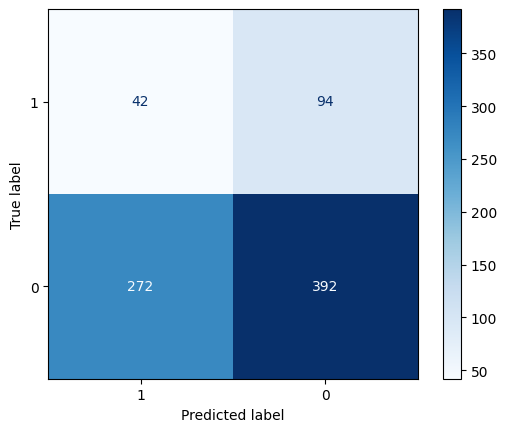

In [22]:
# Evaluate the Naive Bayes classifier on the test data
y_pred_nb, yhat_nb, fpr_nb, tpr_nb, auc_nb = inference(classifier_nb, x_test, y_test)

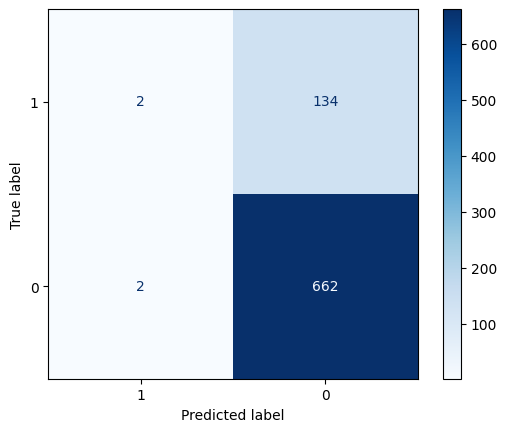

In [23]:
# Evaluate the Decision Tree classifier on the test data
y_pred_dt, yhat_dt, fpr_dt, tpr_dt, auc_dt = inference(classifier_dt, x_test, y_test)

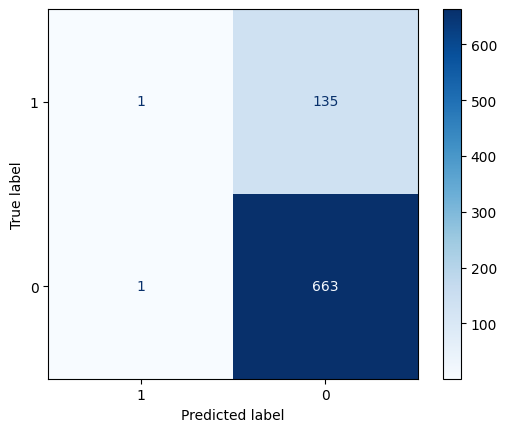

In [24]:
# Evaluate the K-Nearest Neighbors classifier on the test data
y_pred_knn, yhat_knn, fpr_knn, tpr_knn, auc_knn = inference(classifier_knn, x_test, y_test)

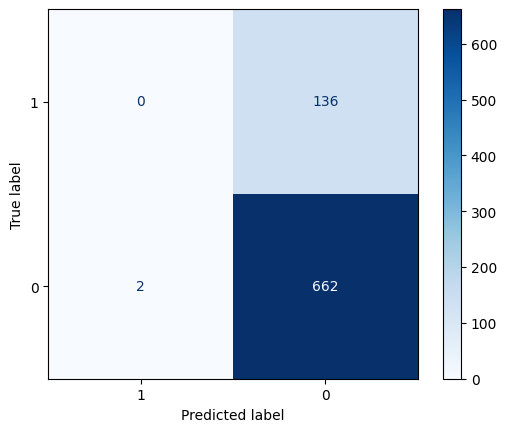

In [25]:
# Evaluate the Logistic Regression classifier on the test data
y_pred_lr, yhat_lr, fpr_lr, tpr_lr, auc_lr = inference(classifier_lr, x_test, y_test)

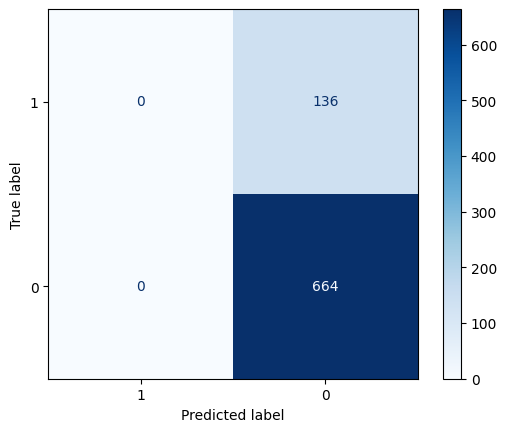

In [26]:
# Evaluate the Random Forest classifier on the test data
y_pred_rf, yhat_rf, fpr_rf, tpr_rf, auc_rf = inference(classifier_rf, x_test, y_test)

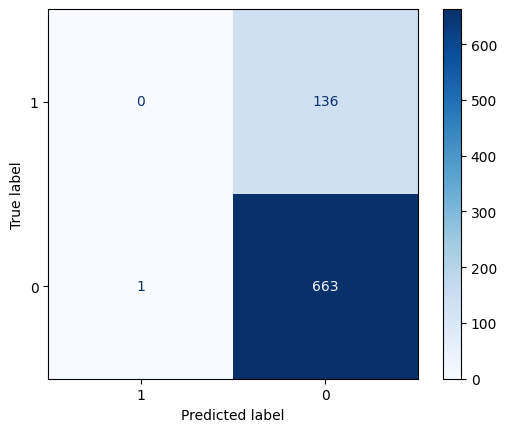

In [27]:
# Evaluate the SVM classifier on the test data
y_pred_svm, yhat_svm, fpr_svm, tpr_svm, auc_svm = inference(classifier_svm, x_test, y_test)

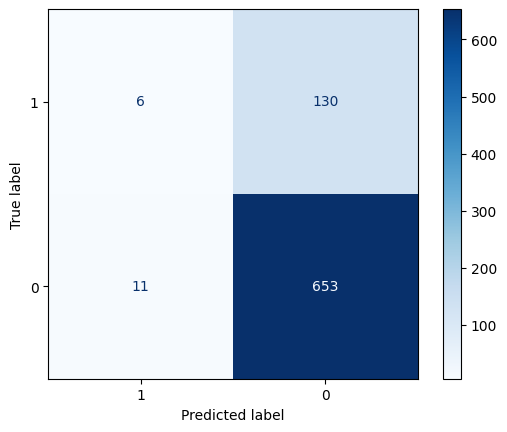

In [28]:
# Evaluate the Random Forest classifier on the test data
y_pred_ada, yhat_ada, fpr_ada, tpr_ada, auc_ada = inference(classifier_ada, x_test, y_test)

### Detailed Metrics for Evaluation

In [29]:
print("------- Machine Learning Results -------")
rf_score = accuracy_score(y_test, y_pred_rf)
knn_score = accuracy_score(y_test, y_pred_knn)
lr_score = accuracy_score(y_test, y_pred_lr)
dt_score = accuracy_score(y_test, y_pred_dt)
np_score = accuracy_score(y_test, y_pred_nb)
svm_score = accuracy_score(y_test, y_pred_svm)
ada_score = accuracy_score(y_test, y_pred_ada)

print ('--' * 20)
print('Random Forest Accuracy: ', str(rf_score))
print('F1 score: ', f1_score(y_test, y_pred_rf, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('K-Nearest Neighbors Accuracy: ', str(knn_score))
print('F1 score: ', f1_score(y_test, y_pred_knn, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Logistic Regression Accuracy: ',str(lr_score))
print('F1 score: ', f1_score(y_test, y_pred_lr, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Decision Tree Accuracy: ', str(dt_score))
print('F1 score: ', f1_score(y_test, y_pred_dt, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('Naive Bayes Accuracy: ', str(np_score))
print('F1 score: ', f1_score(y_test, y_pred_nb, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('SVM Accuracy: ', str(svm_score))
print('F1 score: ', f1_score(y_test, y_pred_svm, labels = [1,0]))
print ('--' * 20)
print ('')
print ('--' * 20)
print('AdaBoost Accuracy: ', str(ada_score))
print('F1 score: ', f1_score(y_test, y_pred_ada, labels = [1,0]))
print ('--' * 20)

------- Machine Learning Results -------
----------------------------------------
Random Forest Accuracy:  0.83
F1 score:  0.0
----------------------------------------

----------------------------------------
K-Nearest Neighbors Accuracy:  0.83
F1 score:  0.014492753623188406
----------------------------------------

----------------------------------------
Logistic Regression Accuracy:  0.8275
F1 score:  0.0
----------------------------------------

----------------------------------------
Decision Tree Accuracy:  0.83
F1 score:  0.02857142857142857
----------------------------------------

----------------------------------------
Naive Bayes Accuracy:  0.5425
F1 score:  0.18666666666666668
----------------------------------------

----------------------------------------
SVM Accuracy:  0.82875
F1 score:  0.0
----------------------------------------

----------------------------------------
AdaBoost Accuracy:  0.82375
F1 score:  0.0784313725490196
------------------------------------

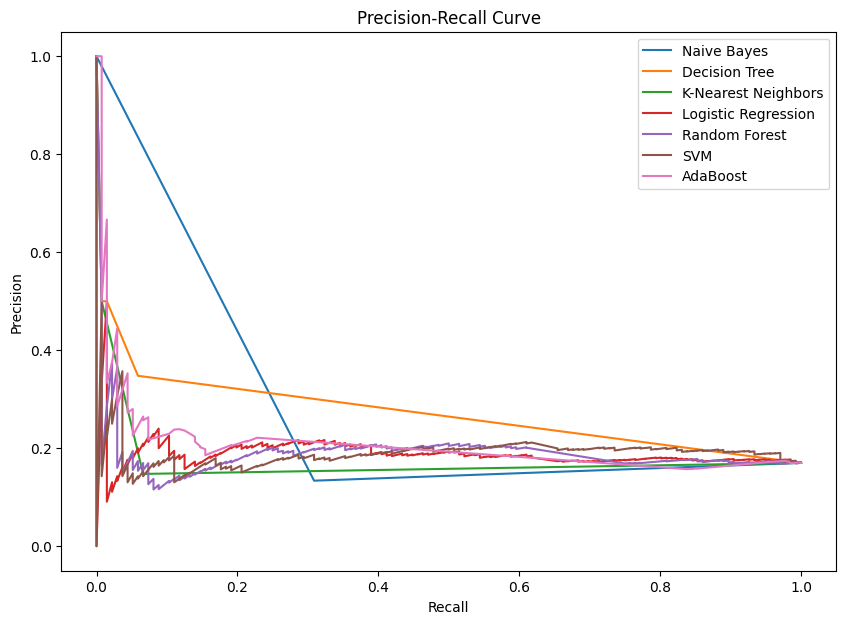

In [30]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get prediction scores for each classifier (use `predict_proba` if available, or `decision_function` if it's an SVM)
y_scores_np = classifier_nb.predict_proba(x_test)[:, 1]
y_scores_dt = classifier_dt.predict_proba(x_test)[:, 1]
y_scores_knn = classifier_knn.predict_proba(x_test)[:, 1]
y_scores_lr = classifier_lr.predict_proba(x_test)[:, 1]
y_scores_rf = classifier_rf.predict_proba(x_test)[:, 1]
y_scores_svm = classifier_svm.decision_function(x_test)
y_scores_ada = classifier_ada.predict_proba(x_test)[:, 1]

# Calculate precision-recall values
prec_np, rec_np, _ = precision_recall_curve(y_test, y_scores_np)
prec_dt, rec_dt, _ = precision_recall_curve(y_test, y_scores_dt)
prec_knn, rec_knn, _ = precision_recall_curve(y_test, y_scores_knn)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_scores_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_scores_rf)
prec_svm, rec_svm, _ = precision_recall_curve(y_test, y_scores_svm)
prec_ada, rec_ada, _ = precision_recall_curve(y_test, y_scores_ada)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 7))
plt.plot(rec_np, prec_np, label="Naive Bayes")
plt.plot(rec_dt, prec_dt, label="Decision Tree")
plt.plot(rec_knn, prec_knn, label="K-Nearest Neighbors")
plt.plot(rec_lr, prec_lr, label="Logistic Regression")
plt.plot(rec_rf, prec_rf, label="Random Forest")
plt.plot(rec_svm, prec_svm, label="SVM")
plt.plot(rec_ada, prec_ada, label="AdaBoost")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

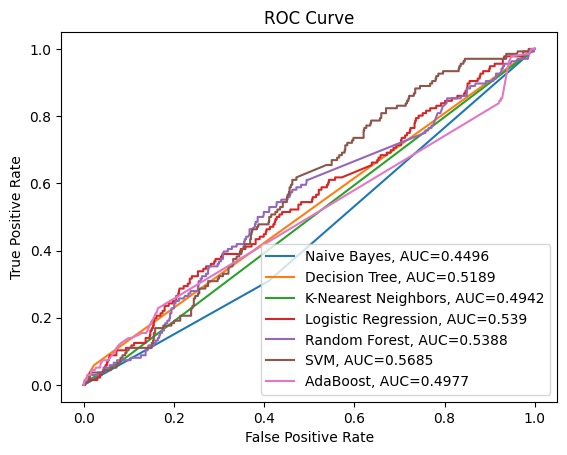

In [31]:
plt.plot(fpr_nb,tpr_nb,label="Naive Bayes, AUC="+str(auc_nb))
plt.plot(fpr_dt,tpr_dt,label="Decision Tree, AUC="+str(auc_dt))
plt.plot(fpr_knn,tpr_knn,label="K-Nearest Neighbors, AUC="+str(auc_knn))
plt.plot(fpr_lr,tpr_lr,label="Logistic Regression, AUC="+str(auc_lr))
plt.plot(fpr_rf,tpr_rf,label="Random Forest, AUC="+str(auc_rf))
plt.plot(fpr_svm,tpr_svm,label="SVM, AUC="+str(auc_svm))
plt.plot(fpr_ada,tpr_ada,label="AdaBoost, AUC="+str(auc_ada))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')

#add legend
plt.legend()

### Inference Using Saved ML-Based Model

In [33]:
import joblib
from sklearn.metrics import classification_report, accuracy_score

# Load the saved model
model = joblib.load('machine learning models/german/model_svm.pkl')

# Predict on the test set
y_pred = model.predict(x_test)

# Evaluate the predictions
print("Accuracy:", accuracy_score(test['label'], y_pred))
print("\nClassification Report:\n", classification_report(test['label'], y_pred))

Accuracy: 0.82875

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91       664
           1       0.00      0.00      0.00       136

    accuracy                           0.83       800
   macro avg       0.41      0.50      0.45       800
weighted avg       0.69      0.83      0.75       800

